## DNA Sequencing with Machine Learning

In this notebook, we will apply a classification model that predicts the gene class (or gene family) based on the DNA sequence

In [116]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from nltk.util import ngrams
from IPython.display import Image
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, precision_score, recall_score,f1_score

%matplotlib inline

In [54]:
human_data = pd.read_table('human_data.txt')
human_data.head()

,sequence,class
0,ATGCCCCAACTAAATACTACCGTATGGCCCACCATAATTACCCCCA...,4
1,ATGAACGAAAATCTGTTCGCTTCATTCATTGCCCCCACAATCCTAG...,4
2,ATGTGTGGCATTTGGGCGCTGTTTGGCAGTGATGATTGCCTTTCTG...,3
3,ATGTGTGGCATTTGGGCGCTGTTTGGCAGTGATGATTGCCTTTCTG...,3
4,ATGCAACAGCATTTTGAATTTGAATACCAGACCAAAGTGGATGGTG...,3


In this notebook, we will use three datasets containing DNA sequences of humans, chimpanzees and dogs. For every instance, 
a class label has been provided as the target variable.

In [55]:
chimp_data = pd.read_table('chimp_data.txt')
dog_data = pd.read_table('dog_data.txt')
chimp_data.head()

,sequence,class
0,ATGCCCCAACTAAATACCGCCGTATGACCCACCATAATTACCCCCA...,4
1,ATGAACGAAAATCTATTCGCTTCATTCGCTGCCCCCACAATCCTAG...,4
2,ATGGCCTCGCGCTGGTGGCGGTGGCGACGCGGCTGCTCCTGGAGGC...,4
3,ATGGCCTCGCGCTGGTGGCGGTGGCGACGCGGCTGCTCCTGGAGGC...,4
4,ATGGGCAGCGCCAGCCCGGGTCTGAGCAGCGTGTCCCCCAGCCACC...,6


In [56]:
dog_data.head()

,sequence,class
0,ATGCCACAGCTAGATACATCCACCTGATTTATTATAATCTTTTCAA...,4
1,ATGAACGAAAATCTATTCGCTTCTTTCGCTGCCCCCTCAATAATAG...,4
2,ATGGAAACACCCTTCTACGGCGATGAGGCGCTGAGCGGCCTGGGCG...,6
3,ATGTGCACTAAAATGGAACAGCCCTTCTACCACGACGACTCATACG...,6
4,ATGAGCCGGCAGCTAAACAGAAGCCAGAACTGCTCCTTCAGTGACG...,0


In the following image, we have outlined the corresponding gene families for class lables in human_data.txt along with the frequency of occurance in the data

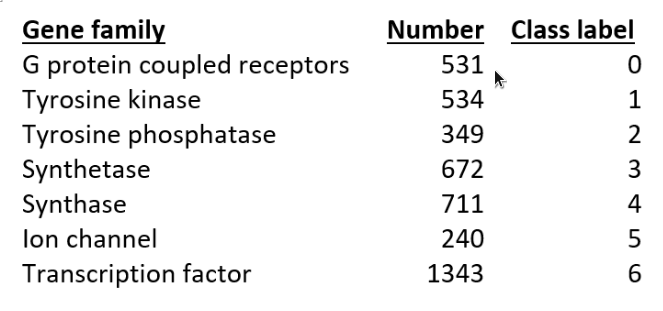

In [57]:
Image("Capture.png")

### Treating DNA sequence as a language, otherwise known as k-mer counting

DNA can be viewed metaphorically as the language of life. This language encodes instructions as well as function for the molecules that are found in all life forms. Furthering this language analogy, the genome can be thought of as the book, subsequences as sentences and chapters, k-mers and peptides as words and nucleotide bases and amino acids as the alphabet. Since this analogy seems so apt,, ti stands to reason that the amazing work done in the field of Natural Language Processing should also apply to the natural language of DNA sequencing.

The NLP-like methodology used here breaks down the DNA sequence to hexamers (words of length 6). In genomics, we refer to these types of manipulations as 'k-mer counting' or counting the occurances of each possible k-mer sequence.

In [58]:
def getKmers(sequence, size = 6):
    return list(sequence[x:x+size].lower() for x in range(len(sequence)-size+1))

In [59]:
getKmers('0123456789', size = 6)

['012345', '123456', '234567', '345678', '456789']

In [60]:
def getAlternateKmers(sequence, size = 6):
    return(list(map("".join,list(ngrams(sequence,size)))))

In [61]:
getAlternateKmers('0123456789', size = 6)

['012345', '123456', '234567', '345678', '456789']

Next, we convert DNA sequences in the dataset to overlapping hexamers

In [62]:
human_data['words']= human_data['sequence'].apply(lambda x: getKmers(x))
human_data.drop('sequence', axis =1, inplace = True)
human_data.head()

,class,words
0,4,"[atgccc, tgcccc, gcccca, ccccaa, cccaac, ccaac..."
1,4,"[atgaac, tgaacg, gaacga, aacgaa, acgaaa, cgaaa..."
2,3,"[atgtgt, tgtgtg, gtgtgg, tgtggc, gtggca, tggca..."
3,3,"[atgtgt, tgtgtg, gtgtgg, tgtggc, gtggca, tggca..."
4,3,"[atgcaa, tgcaac, gcaaca, caacag, aacagc, acagc..."


Next, we'll convert the hexamers into string sentences by joining the list with a blank space. Then, we will implement k-mer counting by passing these converted strings to sklearn's countvectorizer, thereby generating a frequency distribution of all possible hexamers for every DNA sequence.

In [65]:
human_data['items'] = human_data['words'].apply(lambda x:' '.join(x))

In [67]:
human_data.head()

,class,words,items
0,4,"[atgccc, tgcccc, gcccca, ccccaa, cccaac, ccaac...",atgccc tgcccc gcccca ccccaa cccaac ccaact caac...
1,4,"[atgaac, tgaacg, gaacga, aacgaa, acgaaa, cgaaa...",atgaac tgaacg gaacga aacgaa acgaaa cgaaaa gaaa...
2,3,"[atgtgt, tgtgtg, gtgtgg, tgtggc, gtggca, tggca...",atgtgt tgtgtg gtgtgg tgtggc gtggca tggcat ggca...
3,3,"[atgtgt, tgtgtg, gtgtgg, tgtggc, gtggca, tggca...",atgtgt tgtgtg gtgtgg tgtggc gtggca tggcat ggca...
4,3,"[atgcaa, tgcaac, gcaaca, caacag, aacagc, acagc...",atgcaa tgcaac gcaaca caacag aacagc acagca cagc...


In [72]:
human_texts = human_data['items']
y = human_data['class']

Now let's convert the string of hexamers to numerical vectors of uniform length that represent the frequency of every word in the vocabulary. In NLP, we refer to this techique as 'Bag of Words' model and in genomology, this is known as k-mers counting.

In [78]:
cv = CountVectorizer(ngram_range = (4,4))
X = cv.fit_transform(human_texts)
X.shape

(4380, 232414)

Before we proceed with machine learning models, let's take a brief look at the class distribution of the target variable y

In [81]:
value_counts = y.value_counts()

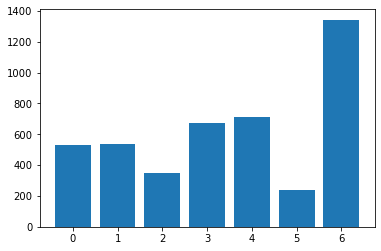

In [83]:
plt.figure()
plt.bar(value_counts.index, value_counts.values)
plt.show()

Since we have successfully vectorized the textual data and we do not observe an imbalance in the frequency distribution of the target variable, we can split the dataset in train and test sets and train a Naive Bayes model on the data. Lastly, we'll be testing the performance of our Naive Bayes Classifier on the test set and reporting the results. 

In [86]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [89]:
from sklearn.naive_bayes import MultinomialNB
classifier = MultinomialNB(alpha = 0.1)
classifier.fit(X_train, y_train)

MultinomialNB(alpha=0.1)

In [90]:
y_pred = classifier.predict(X_test)

Now that we have trained the Naive Bayes classifier and predicted values for the hold out test set, let's evaluate the performance of the model by calculating key performance metrics: precision, recall, f1 score, confusion matrix and accuracy

In [113]:
confusion_matrix(y_test, y_pred)

array([[ 99,   0,   0,   0,   1,   0,   2],
       [  0, 104,   0,   0,   0,   0,   2],
       [  0,   0,  78,   0,   0,   0,   0],
       [  0,   0,   0, 124,   0,   0,   1],
       [  1,   0,   0,   0, 143,   0,   5],
       [  0,   0,   0,   0,   0,  51,   0],
       [  1,   0,   0,   1,   0,   0, 263]])

In [109]:
np.mean(np.array(precision_recall_fscore_support(y_test, y_pred)), axis =1)

array([  0.98980336,   0.98512924,   0.98737858, 125.14285714])

In [114]:
precision = precision_score(y_test, y_pred,average = 'weighted')
f1 = f1_score(y_test, y_pred,average = 'weighted')
recall = recall_score(y_test, y_pred,average = 'weighted')

In [115]:
print(f'precision: {precision}, recall:{recall}, f1_score:{f1}')

precision: 0.984290543482443, recall:0.9840182648401826, f1_score:0.9840270014702487


We observe that the model performs well for all evaluation metrics. In subsequent notebooks, we will delve into chimpanzee and dog data